In [1]:
import pandas as pd
import numpy as np
from utils import dataloader, add_features, data_split, scale, plot_model_comparison, plot_train_test_predictions, run_single_inference
from utils import create_sequences, create_lstm_model, create_gru_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib


# Data Preprocessing

In [2]:
df = dataloader()
df = add_features(df)

f:\Time-Series-Forecasting\utils.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Close'].resample('M').ffill().pct_change().shift(1)
f:\Time-Series-Forecasting\utils.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_return = monthly_return.fillna(method='bfill')


In [3]:
features = [
    'MA5', 'MA10', 'MA20', 'Momentum_1d', 
    'Momentum_5d', 'Monthly_Return', 'Open', 'High', 'Low', 'Close'
]


In [4]:
X = df[features]
y = df['target']

# Data Splitting

In [5]:
# Split data

test_size = 0.2
X_train, X_test, y_train, y_test = data_split(X, y, test_size=test_size)

# Calculate split index for plotting
split_idx = int(len(df) * (1 - test_size))



# Data Scaling

In [6]:
# Scale data

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale(X_train, X_test, y_train, y_test)

In [7]:
# Set style for plots
plt.style.use('dark_background')


model_results = {}
models = {}



In [8]:
# Get actual test prices
y_test_original = df['target'][split_idx:].values

# Machine Learning Models

In [9]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)
lr_pred_scaled = lr_model.predict(X_test_scaled)
lr_pred = y_scaler.inverse_transform(lr_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
lr_mse = mean_squared_error(y_test_scaled, lr_pred_scaled)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_scaled, lr_pred_scaled)
lr_r2 = r2_score(y_test_scaled, lr_pred_scaled)

model_results['Linear Regression'] = {
    'MSE': lr_mse,
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2
}
models['Linear Regression'] = lr_model

print("Linear Regression Model Performance:")
for metric, value in model_results['Linear Regression'].items():
    print(f"{metric}: {value:.4f}")

Linear Regression Model Performance:
MSE: 0.0005
RMSE: 0.0212
MAE: 0.0157
R²: 0.9714


In [10]:
joblib.dump(lr_model, 'lr_model.pkl')

['lr_model.pkl']

In [11]:
run_single_inference("Linear Regression", models, X_test_scaled, y_test_scaled, y_scaler, model_type="default")


--- Inference for Linear Regression ---
Sample Index: 99
Predicted Value: 297.8538
Actual Value:    289.9133
Absolute Error:  7.9405
Accuracy:        97.26%



Plotting results for Linear Regression model


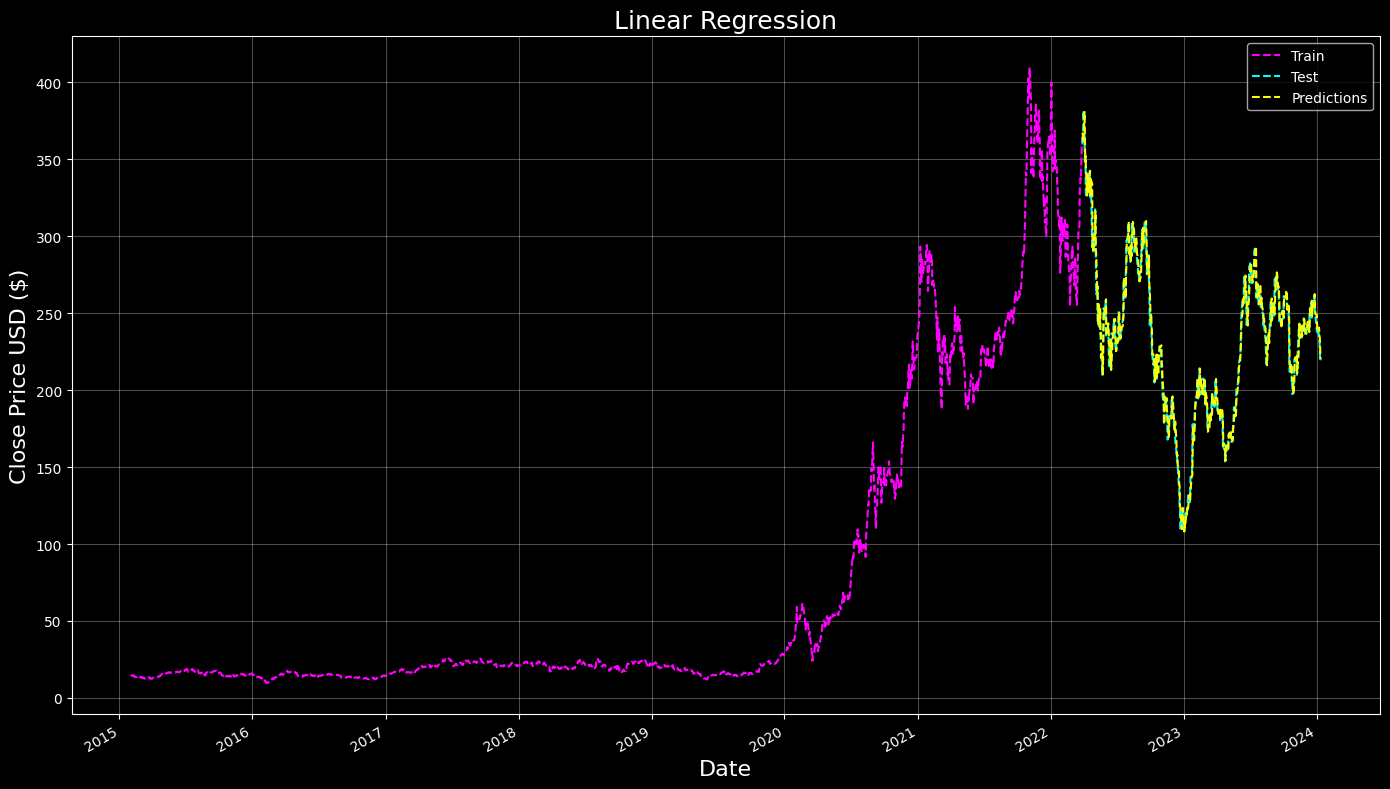

In [12]:

print(f"\nPlotting results for Linear Regression model")
plot_train_test_predictions(df, split_idx, y_test_original, lr_pred, model_name="Linear Regression")

In [13]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled)
rf_pred_scaled = rf_model.predict(X_test_scaled)
rf_pred = y_scaler.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
rf_mse = mean_squared_error(y_test_scaled, rf_pred_scaled)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test_scaled, rf_pred_scaled)
rf_r2 = r2_score(y_test_scaled, rf_pred_scaled)

model_results['Random Forest'] = {
    'MSE': rf_mse,
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'R²': rf_r2
}
models['Random Forest'] = rf_model

print("Random Forest Model Performance:")
for metric, value in model_results['Random Forest'].items():
    print(f"{metric}: {value:.4f}")

Random Forest Model Performance:
MSE: 0.0008
RMSE: 0.0291
MAE: 0.0222
R²: 0.9461


In [14]:
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [15]:
run_single_inference("Random Forest", models, X_test_scaled, y_test_scaled, y_scaler, model_type="default")



--- Inference for Random Forest ---
Sample Index: 284
Predicted Value: 181.8282
Actual Value:    173.8600
Absolute Error:  7.9682
Accuracy:        95.42%



Plotting results for Random Forest model


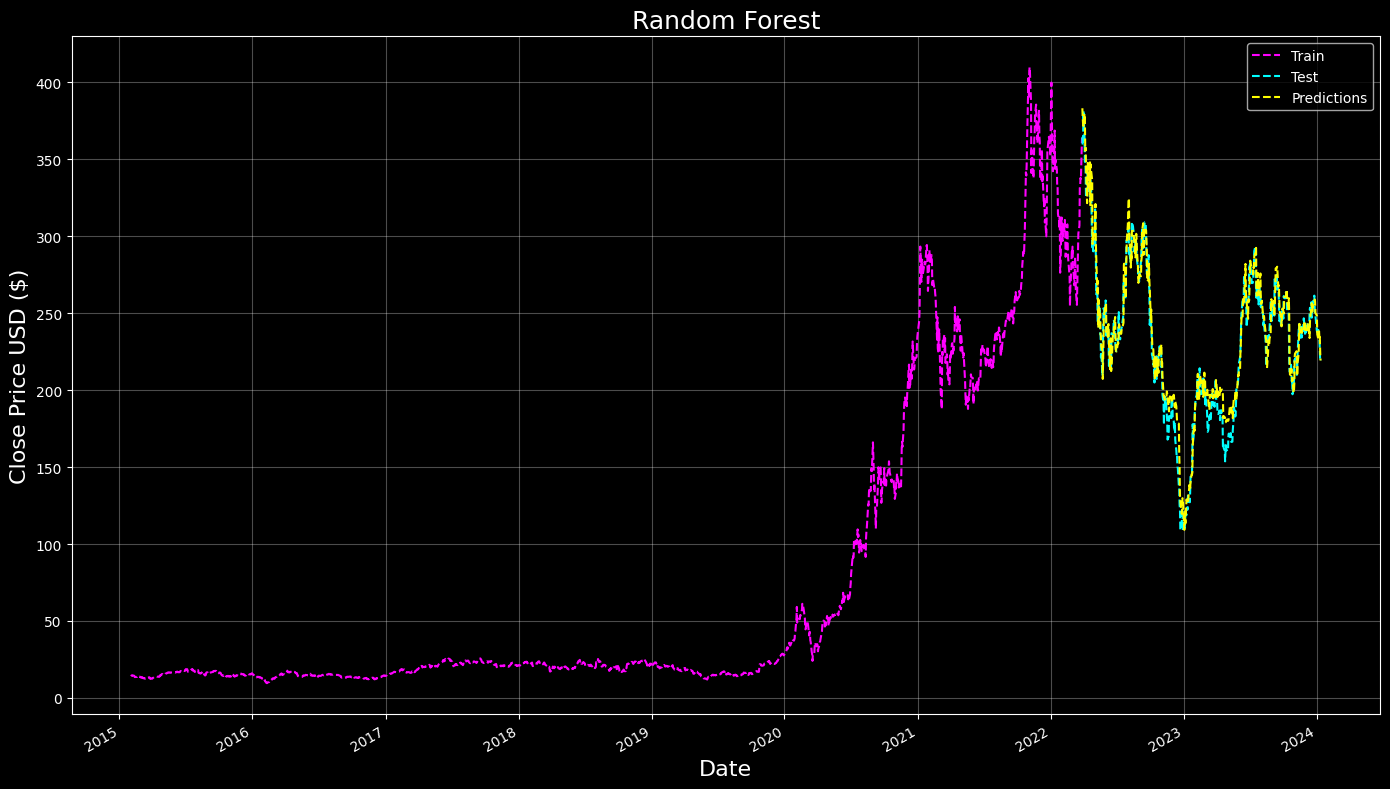

In [16]:

print(f"\nPlotting results for Random Forest model")
plot_train_test_predictions(df, split_idx, y_test_original, rf_pred, model_name="Random Forest")

In [17]:
# XGBoost Model
import xgboost as xgb


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train_scaled)
xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = y_scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
xgb_mse = mean_squared_error(y_test_scaled, xgb_pred_scaled)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_scaled, xgb_pred_scaled)
xgb_r2 = r2_score(y_test_scaled, xgb_pred_scaled)

model_results['XGBoost'] = {
    'MSE': xgb_mse,
    'RMSE': xgb_rmse,
    'MAE': xgb_mae,
    'R²': xgb_r2
}
models['XGBoost'] = xgb_model

print("XGBoost Model Performance:")
for metric, value in model_results['XGBoost'].items():
    print(f"{metric}: {value:.4f}")


XGBoost Model Performance:
MSE: 0.0008
RMSE: 0.0279
MAE: 0.0217
R²: 0.9505


In [18]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [19]:
run_single_inference("XGBoost", models, X_test_scaled, y_test_scaled, y_scaler, model_type="default")



--- Inference for XGBoost ---
Sample Index: 217
Predicted Value: 199.3914
Actual Value:    207.3200
Absolute Error:  7.9286
Accuracy:        96.18%



Plotting results for XGBoost


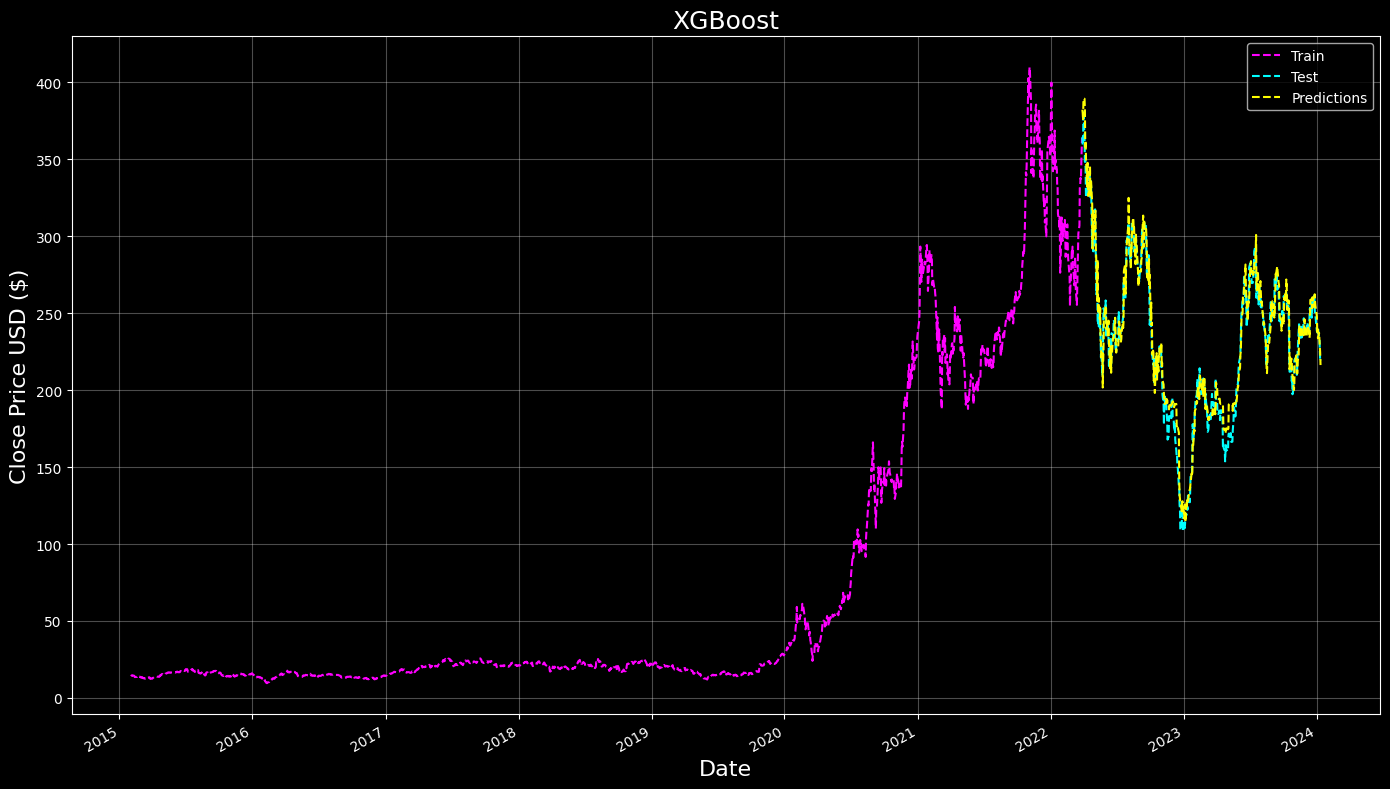

In [20]:
print(f"\nPlotting results for XGBoost")
plot_train_test_predictions(df, split_idx, y_test_original, xgb_pred, model_name="XGBoost")

In [21]:
# Decision Tree Model
from sklearn.tree import DecisionTreeRegressor


dt_model = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train_scaled, y_train_scaled)
dt_pred_scaled = dt_model.predict(X_test_scaled)
dt_pred = y_scaler.inverse_transform(dt_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
dt_mse = mean_squared_error(y_test_scaled, dt_pred_scaled)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test_scaled, dt_pred_scaled)
dt_r2 = r2_score(y_test_scaled, dt_pred_scaled)

model_results['Decision Tree'] = {
    'MSE': dt_mse,
    'RMSE': dt_rmse,
    'MAE': dt_mae,
    'R²': dt_r2
}
models['Decision Tree'] = dt_model

print("Decision Tree Model Performance:")
for metric, value in model_results['Decision Tree'].items():
    print(f"{metric}: {value:.4f}")

Decision Tree Model Performance:
MSE: 0.0015
RMSE: 0.0392
MAE: 0.0290
R²: 0.9024


In [22]:
joblib.dump(dt_model, 'dt_model.pkl')

['dt_model.pkl']

In [23]:
run_single_inference("Decision Tree", models, X_test_scaled, y_test_scaled, y_scaler, model_type="default")



--- Inference for Decision Tree ---
Sample Index: 44
Predicted Value: 250.0599
Actual Value:    258.3333
Absolute Error:  8.2734
Accuracy:        96.80%



Plotting results for Decision Tree model


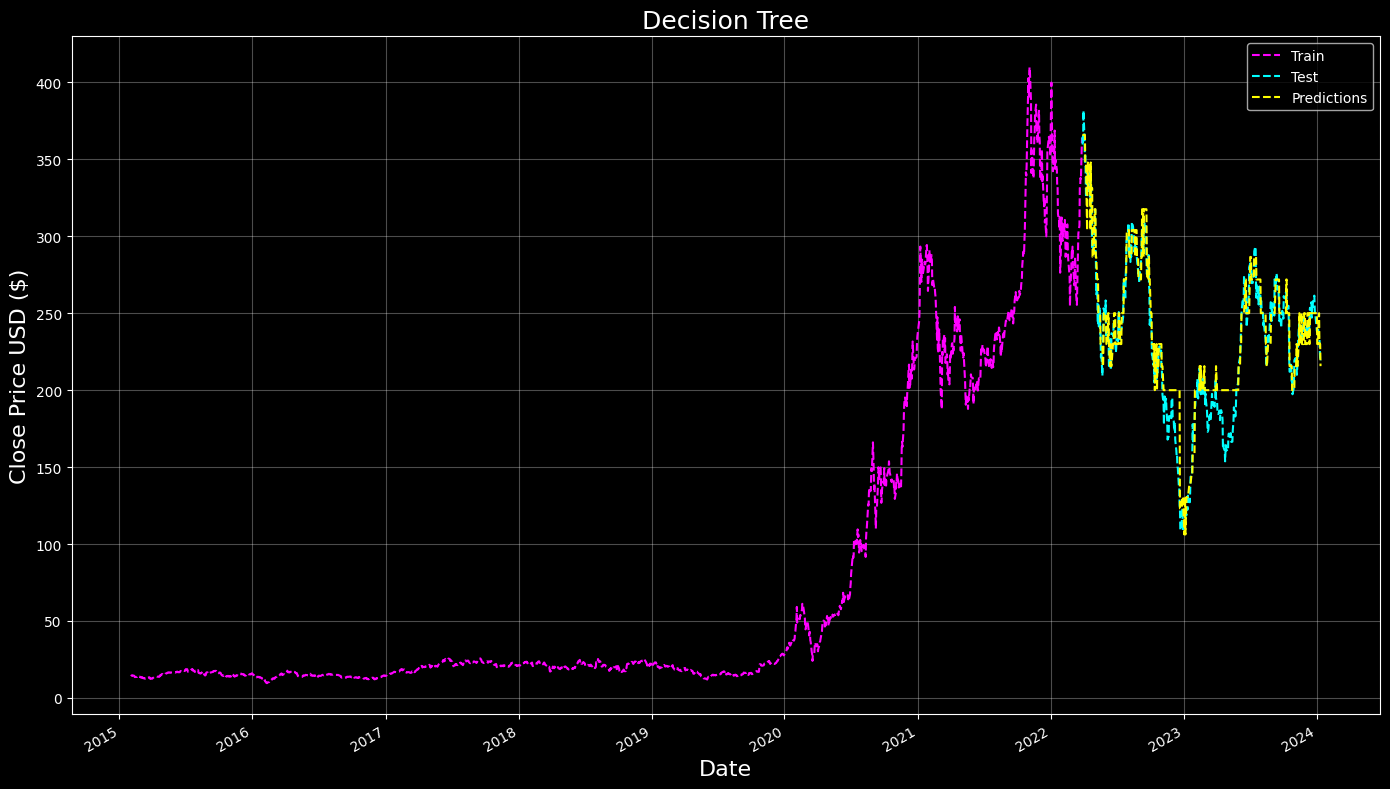

In [24]:
print(f"\nPlotting results for Decision Tree model")
plot_train_test_predictions(df, split_idx, y_test_original, dt_pred, model_name="Decision Tree")

In [25]:
# SVR Model 
from sklearn.svm import SVR


svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)
svr_pred_scaled = svr_model.predict(X_test_scaled)
svr_pred = y_scaler.inverse_transform(svr_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
svr_mse = mean_squared_error(y_test_scaled, svr_pred_scaled)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_scaled, svr_pred_scaled)
svr_r2 = r2_score(y_test_scaled, svr_pred_scaled)

model_results['SVR'] = {
    'MSE': svr_mse,
    'RMSE': svr_rmse,
    'MAE': svr_mae,
    'R²': svr_r2
}
models['SVR'] = svr_model

print("SVR Model Performance:")
for metric, value in model_results['SVR'].items():
    print(f"{metric}: {value:.4f}")

SVR Model Performance:
MSE: 0.0014
RMSE: 0.0368
MAE: 0.0306
R²: 0.9141


In [26]:
joblib.dump(svr_model, 'svr_model.pkl')

['svr_model.pkl']

In [27]:
run_single_inference("SVR", models, X_test_scaled, y_test_scaled, y_scaler, model_type="default")



--- Inference for SVR ---
Sample Index: 208
Predicted Value: 169.4100
Actual Value:    177.9000
Absolute Error:  8.4900
Accuracy:        95.23%



Plotting results for SVR model


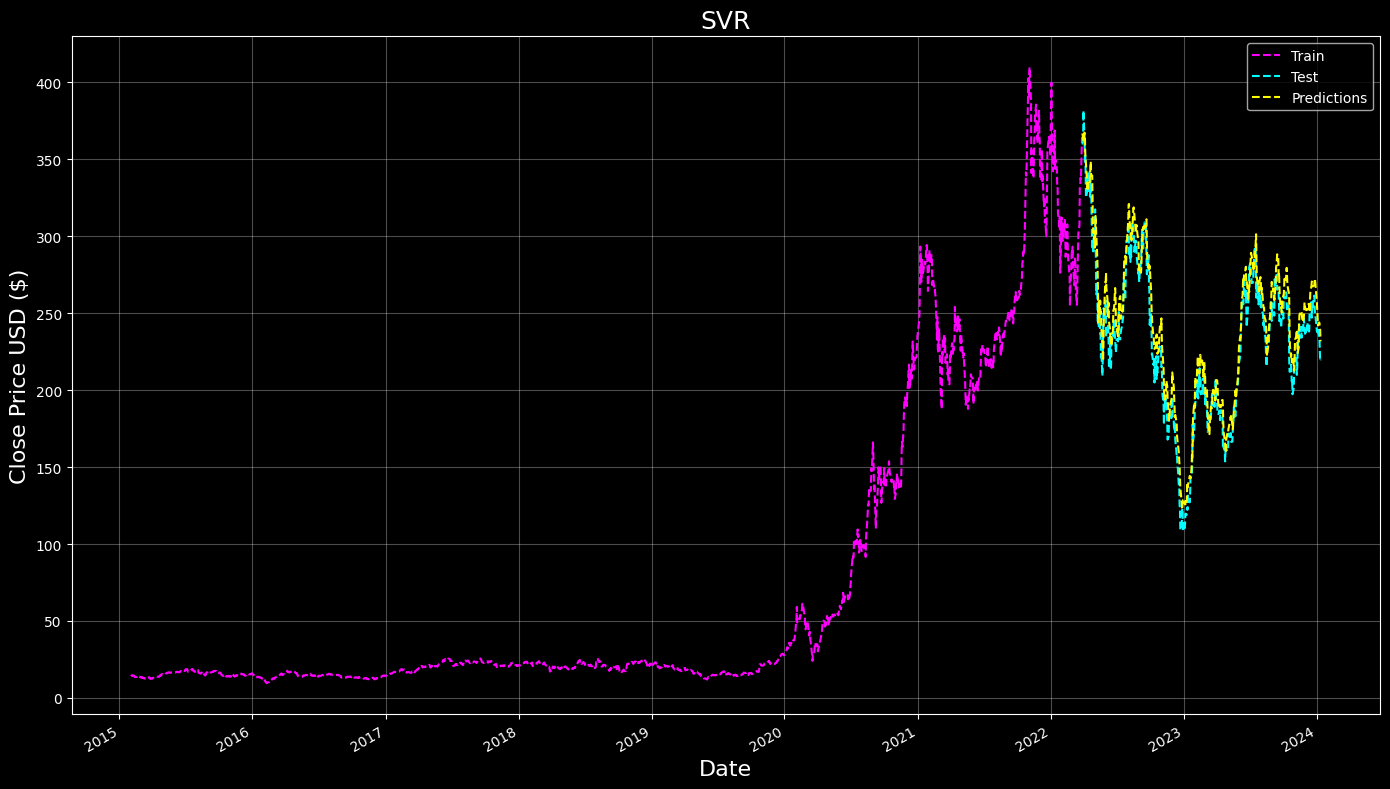

In [28]:
print(f"\nPlotting results for SVR model")
plot_train_test_predictions(df, split_idx, y_test_original, svr_pred, model_name="SVR")

In [29]:


# # Plot the model with the best R² score
# best_model_name = max(model_results, key=lambda x: model_results[x]['R²'])
# best_model = models[best_model_name]
# best_pred_scaled = best_model.predict(X_test_scaled)
# best_pred = y_scaler.inverse_transform(best_pred_scaled.reshape(-1, 1)).flatten()



# # Plot model comparison
# print("\nPlotting model comparison...")
# plot_model_comparison(model_results)


# Deep Learning Models


Preparing data for LSTM model...

Training LSTM model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM Model Performance:
MSE: 0.0028
RMSE: 0.0529
MAE: 0.0433
R²: 0.7991

Plotting LSTM results...


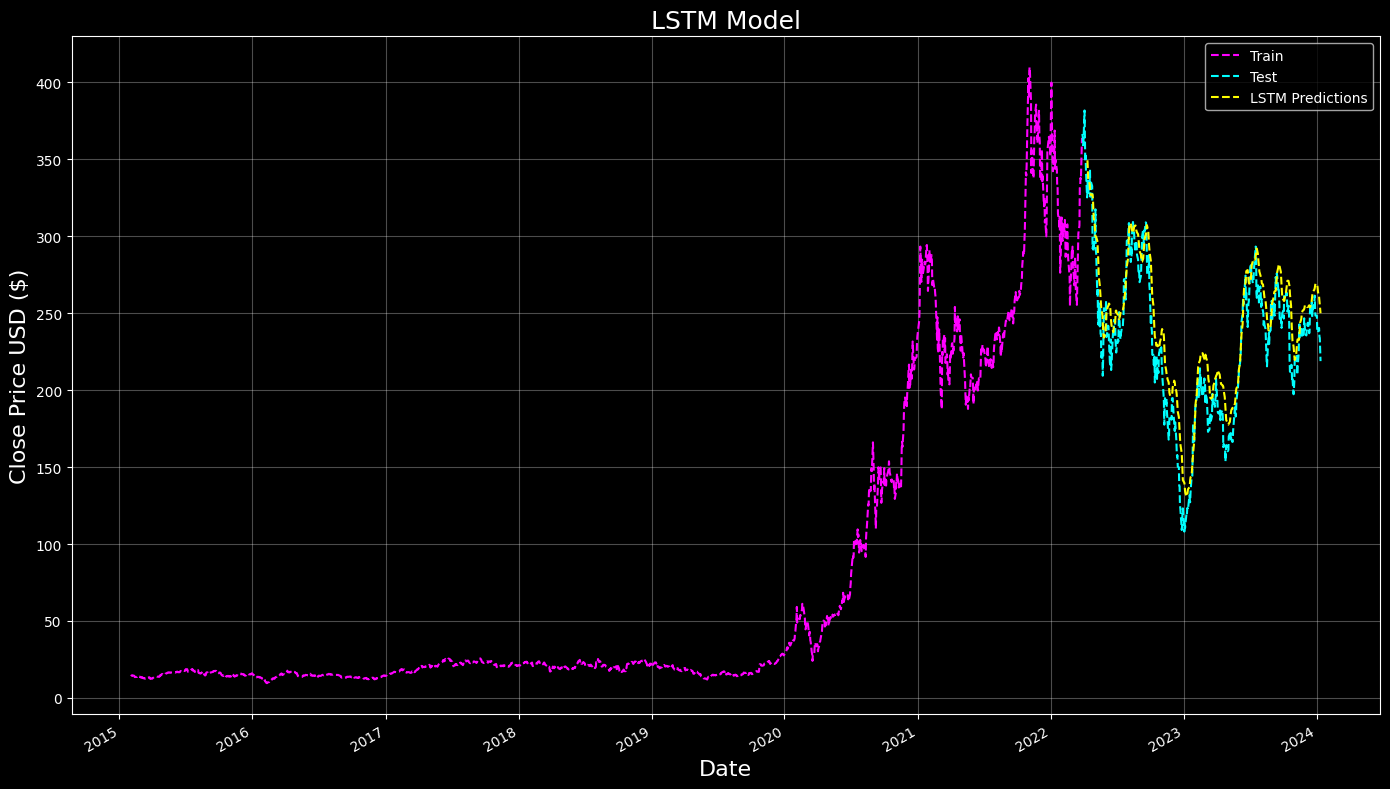

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('dark_background')

    

    
 
    
# -------------------------------------------------
# LSTM Model 
# -------------------------------------------------
print("\nPreparing data for LSTM model...")
# Create sequences for LSTM (timesteps=10)
time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_lstm = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])

print("\nTraining LSTM model...")
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and train LSTM model
lstm_model = create_lstm_model((time_steps, X_train.shape[1]))
lstm_history = lstm_model.fit(
    X_train_lstm, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

# Make predictions
lstm_pred_seq = lstm_model.predict(X_test_lstm)
lstm_pred_scaled = lstm_pred_seq.flatten()

# Handle potential length mismatch due to sequence creation
y_test_lstm = y_test_seq

# Metrics calculation
lstm_mse = mean_squared_error(y_test_lstm, lstm_pred_scaled)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred_scaled)
lstm_r2 = r2_score(y_test_lstm, lstm_pred_scaled)

# Prepare predictions for plotting (inverse transform)
# Handle potential length mismatch for plotting
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()

# Store results
model_results['LSTM'] = {
    'MSE': lstm_mse,
    'RMSE': lstm_rmse,
    'MAE': lstm_mae,
    'R²': lstm_r2
}
models['LSTM'] = lstm_model

print("LSTM Model Performance:")
for metric, value in model_results['LSTM'].items():
    print(f"{metric}: {value:.4f}")




offset = time_steps
lstm_test_dates = df.index[split_idx+offset:split_idx+offset+len(lstm_pred)]

print("\nPlotting LSTM results...")
# plot_train_test_predictions(df, split_idx, y_test_original, lstm_pred, model_name="LSTM")
plt.figure(figsize=(14, 8))
plt.plot(df.index[:split_idx], df['Close'][:split_idx], color='magenta', label='Train', linestyle='--')
plt.plot(df.index[split_idx:], df['Close'][split_idx:], color='cyan', label='Test', linestyle='--')
plt.plot(lstm_test_dates, lstm_pred, color='yellow', label='LSTM Predictions', linestyle='--')
plt.title('LSTM Model', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()



In [30]:
lstm_model.save('models/lstm_model.keras')


In [31]:
run_single_inference("LSTM", models, X_test_lstm, y_test_seq, y_scaler, model_type="lstm", timesteps=10)



--- Inference for LSTM ---
Sample Index: 250
Predicted Value: 206.4640
Actual Value:    185.9000
Absolute Error:  20.5641
Accuracy:        88.94%



Training GRU model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
GRU Model Performance:
MSE: 0.0015
RMSE: 0.0387
MAE: 0.0310
R²: 0.8925

Plotting GRU results...


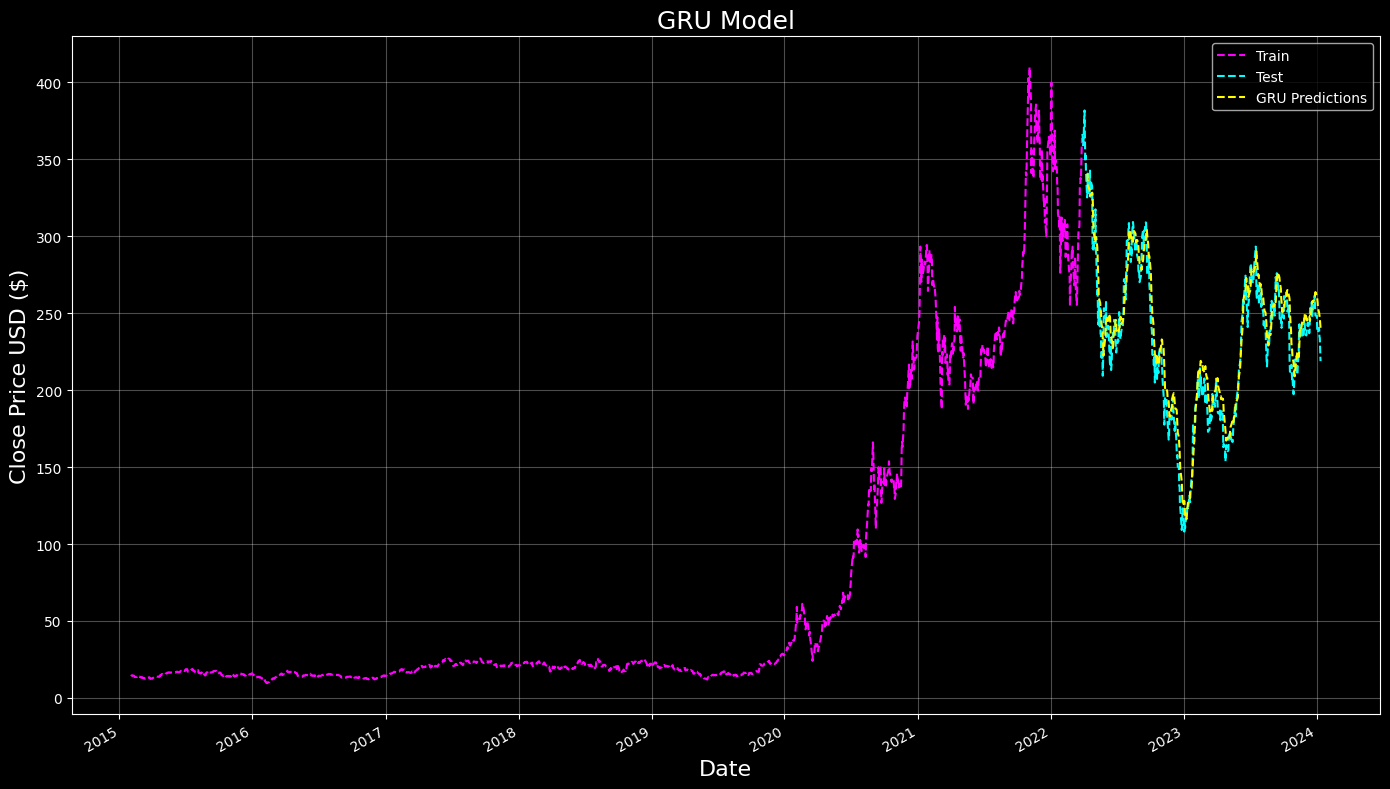

In [32]:
# -------------------------------------------------
# GRU Model 
# -------------------------------------------------
print("\nTraining GRU model...")
# Create and train GRU model
gru_model = create_gru_model((time_steps, X_train.shape[1]))
gru_history = gru_model.fit(
    X_train_lstm, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

# Make predictions
gru_pred_seq = gru_model.predict(X_test_lstm)
gru_pred_scaled = gru_pred_seq.flatten()

# Metrics calculation
gru_mse = mean_squared_error(y_test_lstm, gru_pred_scaled)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test_lstm, gru_pred_scaled)
gru_r2 = r2_score(y_test_lstm, gru_pred_scaled)

# Prepare predictions for plotting
gru_pred = y_scaler.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()

# Store results
model_results['GRU'] = {
    'MSE': gru_mse,
    'RMSE': gru_rmse,
    'MAE': gru_mae,
    'R²': gru_r2
}
models['GRU'] = gru_model

print("GRU Model Performance:")
for metric, value in model_results['GRU'].items():
    print(f"{metric}: {value:.4f}")
    
    
offset = time_steps

gru_test_dates = df.index[split_idx+offset:split_idx+offset+len(gru_pred)]
    



print("\nPlotting GRU results...")
plt.figure(figsize=(14, 8))
plt.plot(df.index[:split_idx], df['Close'][:split_idx], color='magenta', label='Train', linestyle='--')
plt.plot(df.index[split_idx:], df['Close'][split_idx:], color='cyan', label='Test',  linestyle='--')
plt.plot(gru_test_dates, gru_pred, color='yellow', label='GRU Predictions',  linestyle='--')
plt.title('GRU Model', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
    


In [33]:
gru_model.save('models/gru_model.keras')

In [34]:
run_single_inference("GRU", models, X_test_lstm, y_test_seq, y_scaler, model_type="gru", timesteps=10)



--- Inference for GRU ---
Sample Index: 240
Predicted Value: 199.2329
Actual Value:    193.8800
Absolute Error:  5.3528
Accuracy:        97.24%


# Ensemble Model

In [10]:
from tensorflow.keras.models import load_model
import joblib

lstm_model = load_model('./models/lstm_model.keras')
rf_model = joblib.load('rf_model.pkl')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Optimal weights: RF = 0.8957, LSTM = 0.1043
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Evaluation Metrics:

 Ensemble
   MSE: 0.0009
   RMSE: 0.0295
   MAE: 0.0225
   R²: 0.9375

 Random Forest (adjusted)
   MSE: 0.0008
   RMSE: 0.0288
   MAE: 0.0219
   R²: 0.9403

 LSTM
   MSE: 0.0028
   RMSE: 0.0529
   MAE: 0.0433
   R²: 0.7991


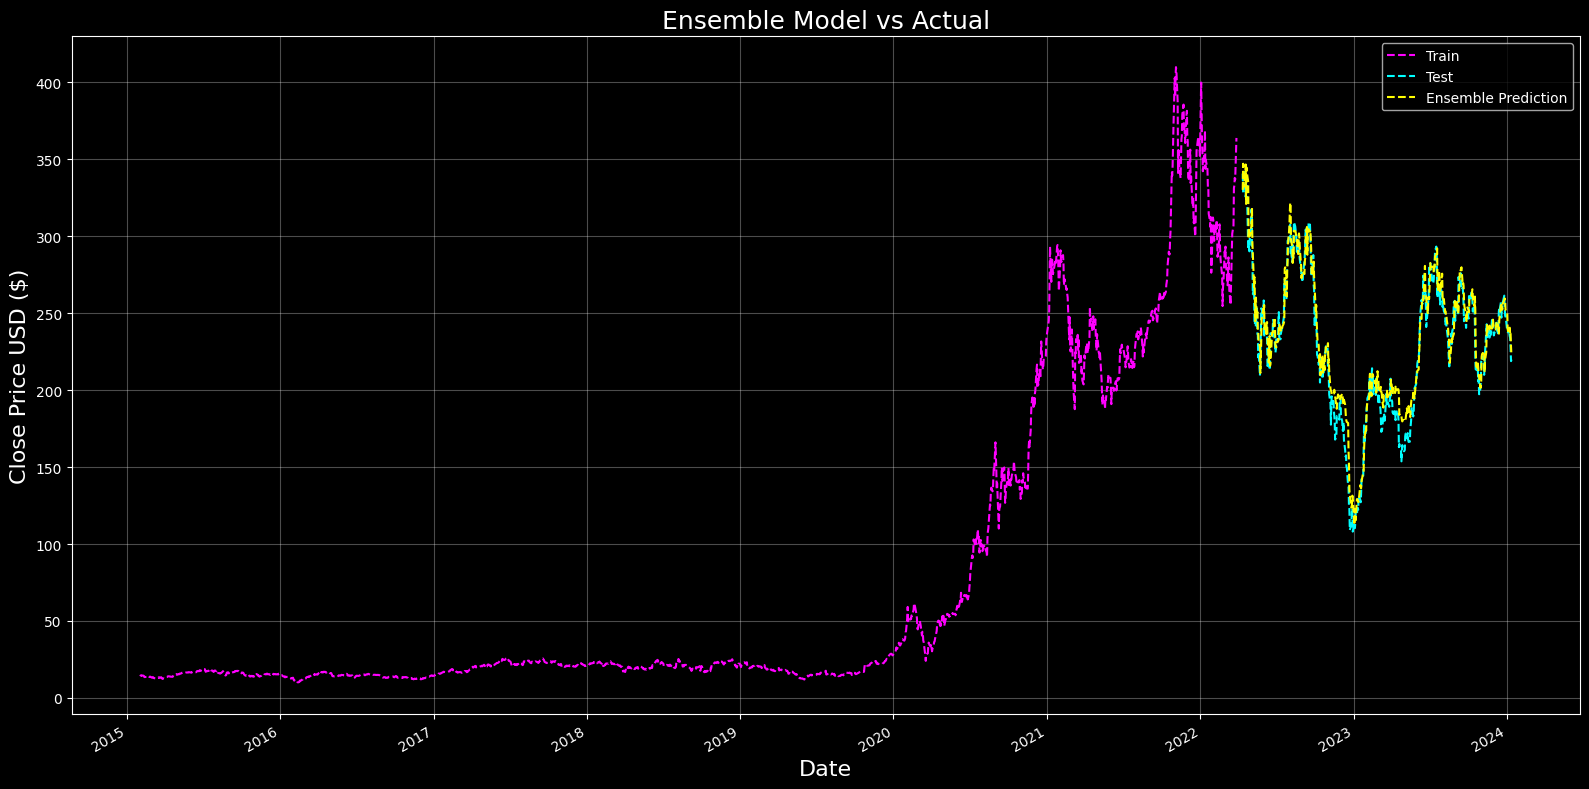

In [11]:
from class_util import EnsembleModel, find_optimal_weights

optimal_weights = find_optimal_weights(
    rf_model=rf_model,
    lstm_model=lstm_model,
    X_test_scaled=X_test_scaled,
    y_test_scaled=y_test_scaled,
    time_steps=10
)

print(f"Optimal weights: RF = {optimal_weights[0]:.4f}, LSTM = {optimal_weights[1]:.4f}")

ensemble = EnsembleModel(
    rf_model=rf_model,
    lstm_model=lstm_model,
    time_steps=10,
    blend_weights=optimal_weights
)

results = ensemble.evaluate(
    X_test_scaled=X_test_scaled,
    y_test_scaled=y_test_scaled,
    y_scaler=y_scaler,
    df=df,
    split_idx=split_idx
)

model_results['Ensemble'] = results['Ensemble']
models['Ensemble'] = ensemble
# Plot model comparison metrics
#plot_model_comparison(results)




In [12]:
joblib.dump(ensemble, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [37]:
from utils import run_single_inference_ensemble

In [38]:
run_single_inference_ensemble(models, X_test_scaled, y_test_scaled, y_scaler, time_steps=10)



--- Ensemble Inference ---
Sample Index:    218
Predicted Value: 210.6670
Actual Value:    196.8900
Absolute Error:  13.7770
Accuracy:        93.00%


In [9]:


# Plot the model with the best R² score
best_model_name = max(model_results, key=lambda x: model_results[x]['R²'])
best_model = models[best_model_name]
best_pred_scaled = best_model.predict(X_test_scaled)
best_pred = y_scaler.inverse_transform(best_pred_scaled.reshape(-1, 1)).flatten()

best_model_name = max(model_results, key=lambda x: model_results[x]['R²'])

# if best_model_name == 'Prophet':
#     # Prophet uses its own prediction dataframe: forecast['yhat_inv']
#     best_pred = forecast['yhat_inv'].values
#     y_true_best = test_df['target'].values
# else:
#     best_model = models[best_model_name]
#     best_pred_scaled = best_model.predict(X_test_scaled)
#     best_pred = y_scaler.inverse_transform(best_pred_scaled.reshape(-1, 1)).flatten()
#     y_true_best = y_test  # Assuming y_test is defined





# Plot model comparison
# print("\nPlotting model comparison...")
plot_model_comparison(model_results)




ValueError: max() arg is an empty sequence

# Statistical Models

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mse= mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}



def run_sarimax_window_pipeline(start_ratio=0.4, test_size=0.2, order=(1,0,1), seasonal_order=(0,0,0,5)):
    # Load and preprocess data
    # df = dataloader()
    # df = add_features(df)

    # exog_features = ['MA5', 'MA10', 'MA20', 'Momentum_1d', 'Momentum_5d', 
    #                  'Monthly_Return', 'Open', 'High', 'Low', 'Close']
    
    series = df['target'].values
    exog = df[features].values

    # Cut initial data using start_ratio
    total_len = len(series)
    start_idx = int(total_len * start_ratio)
    series = series[start_idx:]
    exog = exog[start_idx:]

    # Split data using your data_split + scale functions
    X_train, X_test, y_train, y_test = data_split(exog, series, test_size=test_size)
    #X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = scale(X_train, X_test, y_train, y_test)

    # Fit SARIMAX on unscaled y
    model = SARIMAX(y_train, exog=X_train,
                    order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast on unscaled exogenous test data
    forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

    # Evaluate on original scale
    metrics = evaluate_forecast(y_test, forecast)
    print("SARIMAX (Windowed) Evaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Optional plot
    # plt.style.use('dark_background')
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual')
    plt.plot(np.arange(len(forecast)), forecast, label='Forecast', linestyle='--')
    plt.title("SARIMAX Forecast on Shifted Time Window")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model_fit, metrics


SARIMAX (Windowed) Evaluation Metrics:
MSE: 50.3242
RMSE: 7.0940
MAE: 5.3467
R2: 0.9739


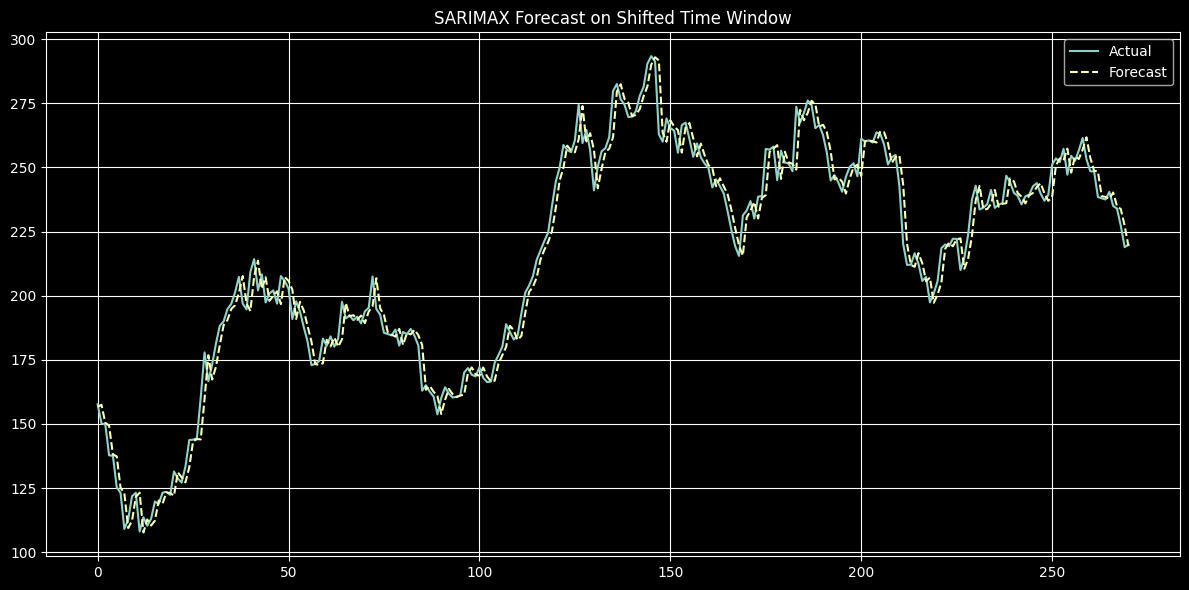

In [41]:
model_fit, metrics= run_sarimax_window_pipeline()

In [24]:
import pandas as pd
from prophet import Prophet


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:

df_prophet=dataloader()
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [26]:
m = Prophet()
m.fit(df_prophet)

13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2634,2025-01-11
2635,2025-01-12
2636,2025-01-13
2637,2025-01-14
2638,2025-01-15


In [28]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2634,2025-01-11,154.975663,109.748813,199.080960
2635,2025-01-12,154.608895,106.336590,198.702629
2636,2025-01-13,154.809057,108.940340,199.927497
2637,2025-01-14,153.723801,108.395383,198.027324
2638,2025-01-15,153.374748,110.205473,198.344227


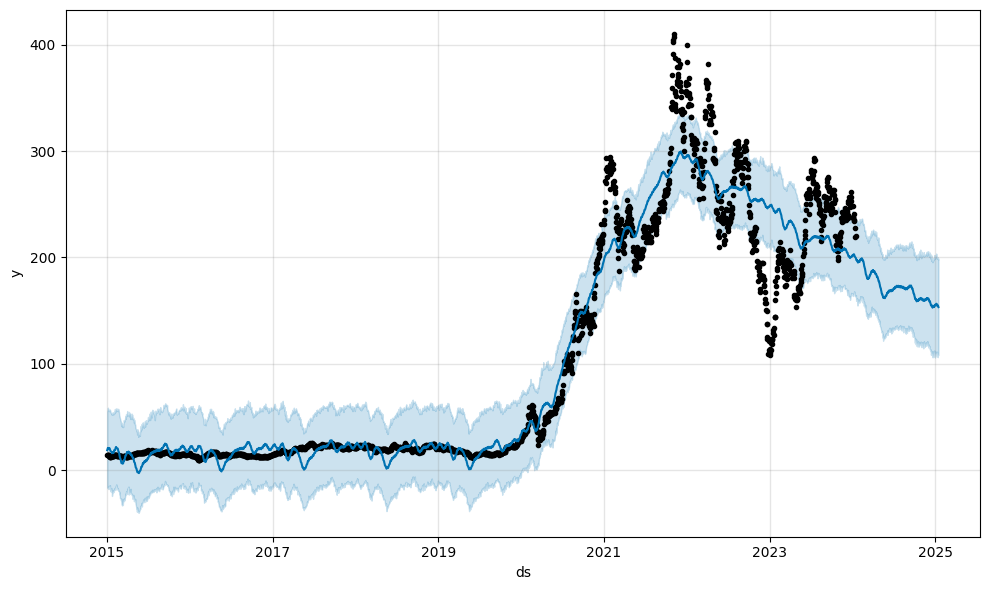

In [29]:
plt.style.use('default')
fig1 = m.plot(forecast)



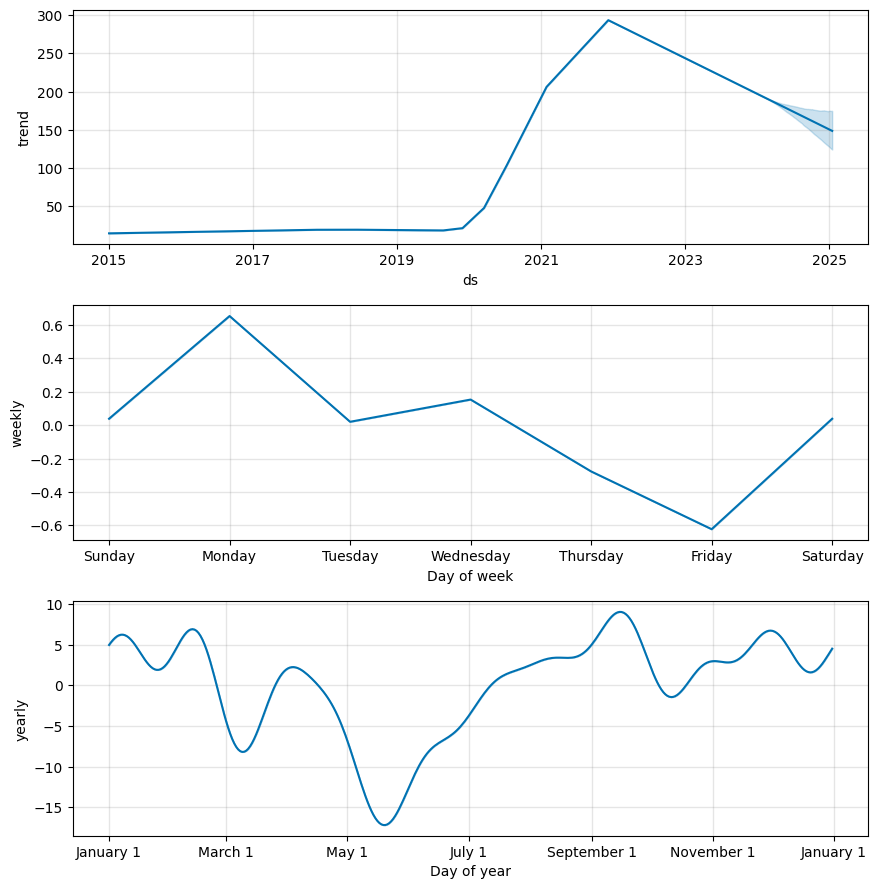

In [48]:
fig2 = m.plot_components(forecast)

In [30]:
import pandas as pd
import plotly.graph_objects as go

# Load the full Tesla data with 2025
df_updated = pd.read_csv('HistoricalData_1747729563629.csv', parse_dates=['Date'])
df_updated = df_updated.reset_index()
  
df_updated = df_updated[['Date', 'Close/Last']]
df_updated = df_updated.rename(columns={'Date': 'ds', 'Close/Last': 'y'})

# Filter only 2025 data (or the date range covered in forecast)
df_actual = df_updated[(df_updated['ds'] >= '2024-01-01') & (df_updated['ds'] <= '2025-01-11')]


In [31]:
import pandas as pd
import plotly.graph_objects as go
from prophet import Prophet

# Load and prepare historical data
df = pd.read_csv('HistoricalData_1747729563629.csv', parse_dates=['Date'])
df = df[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'].replace('[\$,]', '', regex=True).astype(float)  # Remove $ if present

# Fit the Prophet model
model = Prophet()
model.fit(df)

# Forecast future 365 days
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# No filter — use full actual data
df_actual = df.copy()

# Create the plot
fig = go.Figure()

# Full actual data
fig.add_trace(go.Scatter(
    x=df_actual['ds'],
    y=df_actual['y'],
    mode='lines+markers',
    name='Actual (Full)',
    line=dict(color='orange')
))

# Full forecasted values
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Forecast (yhat)',
    line=dict(color='blue')
))

# Confidence interval (optional)
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    name='Upper Confidence',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255,165,0,0.2)',
    line=dict(width=0),
    name='Lower Confidence',
    showlegend=False
))

# Customize layout
fig.update_layout(
    title='Tesla Stock: Full Actual Data vs Prophet Forecast',
    xaxis_title='Date',
    yaxis_title='Stock Price (USD)',
    template='plotly_white'
)

fig.show()


13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and feature engineer
df_pro = dataloader()
df_fe = add_features(df_pro)

# Split data (correct split length)
split_idx = int(len(df_fe) * 0.8)
train_df = df_fe.iloc[:split_idx].copy()
test_df = df_fe.iloc[split_idx:].copy()

# Define regressors
regressors = ['MA5', 'MA10', 'MA20', 'Momentum_1d', 'Momentum_5d',
              'Monthly_Return', 'Open', 'High', 'Low', 'Close']

# Scale regressors
scaler = MinMaxScaler()
train_df[regressors] = scaler.fit_transform(train_df[regressors])
test_df[regressors] = scaler.transform(test_df[regressors])

# Prepare Prophet input
def prepare_prophet_df(df):
    p_df = df.reset_index().rename(columns={'Date': 'ds', 'target': 'y'})
    p_df['y'] = np.log(p_df['y'])  # optional: log-transform
    return p_df

train_p = prepare_prophet_df(train_df)
test_p = prepare_prophet_df(test_df)

# Add regressors to both Prophet inputs
for reg in regressors:
    train_p[reg] = train_df[reg].values
    test_p[reg] = test_df[reg].values

# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_changepoints=80,
    changepoint_range=0.9,
    interval_width=0.9
)

# Add the regressors to model
for reg in regressors:
    model.add_regressor(reg)

# Fit model
model.fit(train_p)

# Predict
forecast = model.predict(test_p)
forecast['yhat_inv'] = np.exp(forecast['yhat'])  # reverse log transform

# Evaluation
y_true = test_df['target'].values
y_pred = forecast['yhat_inv'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n Prophet model performance:")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
f:\Time-Series-Forecasting\utils.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Close'].resample('M').ffill().pct_change().shift(1)
f:\Time-Series-Forecasting\utils.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_return = monthly_return.fillna(method='bfill')
13:34:45 - cmdstanpy - INFO - Chain [1] start processing
13:34:47 - cmdstanpy - INFO - Chain [1] done processing



 Prophet model performance:
MSE  : 227.1639
RMSE : 15.0720
MAE  : 11.5816
R²   : 0.9100


In [8]:
model_results['Prophet'] = {
    'R²': r2,
    'RMSE': rmse,
    'MAE': mae
}



In [14]:
models['Prophet'] = Prophet

In [52]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df.index, y=y_true, mode='lines', name='Actual', line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=test_df.index, y=y_pred, mode='lines', name='Predicted', line=dict(color='blue')))

fig.update_layout(
    title='Prophet Forecast vs Actual',
    xaxis_title='Date',
    yaxis_title='Close Price (USD)',
    template='plotly_white'
)

fig.show()


In [12]:
from tensorflow.keras.models import load_model
import joblib

models['lstm'] = load_model('./models/lstm_model.keras')
models['gru'] = load_model('./models/gru_model.keras')
models['rf'] = joblib.load('./models/rf_model.pkl')
models['lr'] = joblib.load('./models/lr_model.pkl')
models['xgb'] = joblib.load('./models/xgb_model.pkl')
models['dt'] = joblib.load('./models/dt_model.pkl')
models['svr'] = joblib.load('./models/svr_model.pkl')

In [13]:
import pandas as pd

# Load the actual stock prices from CSV (from Nasdaq)
df_actual = pd.read_csv("HistoricalData_1747729563629.csv", parse_dates=["Date"])
df_actual = df_actual[['Date', 'Close/Last']]
df_actual.columns = ['ds', 'y']
df_actual['y'] = df_actual['y'].replace('[\$,]', '', regex=True).astype(float)
df_actual.sort_values('ds', inplace=True)
